In [341]:
# potrzebne importy
import pandas as pd
import pickle
import re
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

In [6]:
# wczytanie danych
users_df = pd.read_json("../data/users.jsonl", lines=True)
sessions_df = pd.read_json("../data/sessions.jsonl", lines=True)
products_df = pd.read_json("../data/products.jsonl", lines=True)

#### Funkcje pomocnicze do przetwarzania danych

In [3]:
def extract_color(products_df):
    for index, row in products_df.iterrows():
        color = re.search("'color': '\w+'", str(row["optional_attributes"]))
        if color != None:
            products_df.loc[index, "color"] = color.group(0)[10:-1]
        else:
            products_df.loc[index, "color"] = None
    return products_df

In [4]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], prefix="", prefix_sep="")
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [5]:
def normalize(df, columns_to_norm):
    for feature_name in df.columns:
        if feature_name in columns_to_norm:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return df

In [645]:
def get_users_views(sessions):
    sess = sessions.copy()
    sess['view'] = sess['event_type'].map(lambda x: 1 if x == "VIEW_PRODUCT" or x == "BUY_PRODUCT" else 0)
    users_views = sess.groupby(['user_id', 'product_id'], as_index=False)['view'].sum()
    
    users_views = pd.pivot_table(users_views, values='view', index='user_id', columns='product_id')
    users_views = users_views.fillna(0)
    users_views = users_views.stack().reset_index()
    users_views = users_views.rename(columns={0:'view'})
    return users_views

In [646]:
def get_product_params(product_id, products):
    ret_product = products.loc[products["product_id"] == product_id]
    ret_product = ret_product.drop(columns="product_id")
    return ret_product
    

## Model naiwny

Model naiwny korzysta z algorytmu K najbliższych sąsiadów. Na podstawie bazy wszystkich produktów obliczane są dystanse podobieństwa pomiędzy produktami na podstawie metryki cosinusowej. Wybrane atrybuty do obliczania metryk to: cena, ścieżka kategorii, ocena użytkownika. Następnie budowana jest tablica krotek: (użytkownik, produkt, liczba wyświetleń produktu) - tablica popularności danego produktu względem użytkownika. Taka tablica jest zbiorem trenującym, dla każdego użytkownika następuje sortowanie produktów malejąco według liczby wyświetleń, następnie dla najpopularniejszego produktu dla każdego użytkownika jest uruchamiany algorytm KNN znajdujący produkty najbardziej podobne do tego najchętniej oglądanego. Gdyby polecane produkty znalazły się już w tych wyświetlonych przez użytkownika to algorytm będzie szukał produktów podobnych dla mniej popularnych pozycji po to, aby użytkownik miał w polecanych produktach tylko te, których sam jeszcze nie widział. 

In [1049]:
def prepare_products_set_basic(products_df):
    products_set = products_df.copy()
    products_set = extract_color(products_set)
    products_set = encode_and_bind(products_set, 'category_path')
    products_set = products_set.drop(columns=["product_name", "brand", "optional_attributes","weight_kg","color", "user_rating_count"])
    products_set = normalize(products_set, ['price', 'user_rating'])
    return products_set

In [1050]:
products_set = prepare_products_set_basic(products_df)

In [1051]:
def train_basic_model(train_set, k=5, algo="brute", metric="cosine"):
    X = products_model_A.drop(columns=["product_id"])
    return NearestNeighbors(n_neighbors=k, algorithm=algo, metric=metric).fit(X)

In [1052]:
nbrs = train_basic_model(products_set)

In [1053]:
# zapis zserializowanego modelu oraz przetworzonych danych do pliku
products_model_A.to_pickle("basic/products.pickle")

with open("basic/model.pickle", "wb") as f:
    pickle.dump(nbrs, f)

In [1054]:
def recommendations_basic(user_id, model, users_views, products, k):
    most_viewed = users_views.loc[users_views["user_id"] == user_id].sort_values(by=["view"], ascending=False)
    most_viewed_products = list(most_viewed["product_id"])
    viewed_products = set(most_viewed[most_viewed["view"] > 0.0]["product_id"])
    
    final_reccomendation = []
    for product in most_viewed_products:
        recommended = model.kneighbors(get_product_params(product, products), return_distance=False)
       
        for recommended_product in recommended[0]:
            recommended_product_id = products.iloc[[recommended_product]]['product_id']
            
            pid = int(recommended_product_id)
            if pid not in viewed_products and pid not in final_reccomendation:
                final_reccomendation.append(int(recommended_product_id))
            if len(final_reccomendation) == k:
                return final_reccomendation

In [1046]:
user_views_data = get_users_views(sessions_df).reset_index()
train_m = np.random.rand(len(user_views_data)) < 0.8
train_data = user_views_data[train_m]
test_data = user_views_data[~train_m]
test_users = users_df.sample(frac = 0.1)["user_id"]

In [1055]:
# ocena poprawności modelu naiwnego
train_data_basic = train_data.copy()
test_data_basic = test_data.copy()
k = 5
correct = 0
for user in test_users:
    recommendations = recommendations_basic(user, nbrs, train_data, products_model_A, k)
    for recommendation in recommendations:
        view = test_data.loc[(test_data['product_id'] == recommendation) & (test_data['user_id'] == user)]['view']
        if view is not None and view.any():
            correct += 1
            
result = correct / (k*len(test_users))

print("{:.4f}".format(result))

0.1200


In [917]:
train_data_basic.to_pickle("basic/train_data.pickle")
test_data_basic.to_pickle("basic/test_data.pickle")

## Model zaawansowany


In [1022]:
import pandas as pd
import re
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, euclidean_distances, cosine_similarity

In [1023]:
local_sessions = sessions_df.copy()
local_sessions['action_points'] = local_sessions['event_type'].map(lambda x: 2 if x == "VIEW_PRODUCT" else 5)
actions_sums = model_B_sessions.groupby(['user_id', 'product_id'], as_index=False)['action_points'].sum()
actions_sums = pd.pivot_table(actions_sums, values='action_points', index='user_id', columns='product_id')
actions_sums = actions_sums.fillna(0)
actions_users = actions_sums.copy()
actions_sums = actions_sums.stack().reset_index().rename(columns={0:"action_points"})
actions_sums["view_ocurred"] = actions_sums['action_points'].apply(lambda x: True if x > 0 else False)

In [1057]:
# podział na zbiory testowy i trenujący
train_data = actions_sums[train_m]
test_data = actions_sums[~train_m]

In [1033]:
user_and_product = pd.merge(train_data, products_df, on="product_id", how="left")
user_and_product = user_and_product[['user_id', 'product_id', 'product_name', 'price', 'user_rating', 'user_rating_count']]
user_and_product = normalize(user_and_product, ["price",'user_rating_count','user_rating'])
products = user_and_product[['product_id', 'product_name', 'price', 'user_rating', 'user_rating_count']].drop_duplicates('product_id')

tfidf_name = TfidfVectorizer()
products_content_name = tfidf_name.fit_transform(products['product_name'].unique())
cosine_sim_name = linear_kernel(products_content_name, products_content_name)

In [1040]:
price_matrix = np.reciprocal(euclidean_distances(np.array(products['price']).reshape(-1, 1)) + 1)
framed_price_matrix = pd.DataFrame(price_matrix,columns=products['product_id'],index=products['product_id'])

rating_mtrx = np.reciprocal(euclidean_distances(np.array(products['user_rating']).reshape(-1, 1)) + 1)
framed_rating_matrix = pd.DataFrame(rating_matrix,columns=products['product_id'],index=products['product_id'])

rating_count_mtrx = np.reciprocal(euclidean_distances(np.array(products['user_rating_count']).reshape(-1, 1)) + 1)
framed_rating_count_matrix = pd.DataFrame(rating_matrix,columns=products['product_id'],index=products['product_id'])

In [1035]:
similarity_matrix = framed_price_matrix.multiply(framed_rating_matrix).multiply(framed_rating_count_matrix).multiply(cosine_sim_name)
content_matrix = actions_users.dot(similarity_matrix)
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id', 0:'score'})

In [1036]:
train_data.to_pickle("train_data_advanced.pickle")
test_data.to_pickle("test_data_advanced.pickle")
actions_sums.to_pickle("user_actions_advanced.pickle")
content_df.to_pickle("content_df_advanced.pickle")

In [1041]:
def get_recommendation_advanced(user_id, content_matrix, train_set, K):
    content_df = content_matrix.loc[content_matrix['user_id'] == user_id]
    content_df = content_df.set_index("product_id")
    user_content_df = content_df.sort_values(by="score", ascending=False)
    indices_to_drop = list(train_set[(train_set["view_ocurred"]==True) & (train_set["user_id"]==user_id)]["product_id"])
    user_content_df = user_content_df.drop(indices_to_drop)
    return list(user_content_df.head(K).index)

In [1058]:
K = 5
correct = 0
for user in test_users:
    recommendations = get_recommendation_advanced(user, content_df, train_data, K)
    for recommendation in recommendations:
        view = test_data[(test_data['product_id'] == recommendation) & (test_data['user_id'] == user)]['view_ocurred']
        if view.any() and view.item() == True:
            correct = correct + 1
result = correct / (K * len(test_users))

print("{:.4f}".format(result))

0.3200


In [930]:
# losowy wybor uzytkownikow do eksperymentu A/B online

basic_model_users_ab = users_df.sample(frac=0.5)
advanced_model_users_ab = users_df.drop(basic_model_users_ab.index)
basic_model_users_ab = list(basic_model_users_ab["user_id"])
advanced_model_users_ab = list(advanced_model_users_ab["user_id"])
print(list(basic_model_users_ab))
print(list(advanced_model_users_ab))

[193, 299, 205, 226, 292, 204, 148, 208, 178, 284, 222, 242, 235, 108, 267, 135, 139, 287, 259, 227, 176, 149, 201, 233, 250, 217, 116, 200, 237, 128, 155, 277, 232, 293, 288, 202, 198, 195, 118, 240, 191, 175, 146, 115, 167, 152, 184, 169, 239, 159, 256, 218, 192, 290, 271, 105, 289, 216, 206, 120, 166, 170, 140, 179, 223, 134, 173, 281, 194, 294, 276, 263, 123, 151, 114, 301, 172, 214, 279, 268, 125, 157, 187, 154, 163, 264, 231, 207, 106, 225, 181, 112, 147, 270, 103, 158, 295, 261, 162, 199]
[102, 104, 107, 109, 110, 111, 113, 117, 119, 121, 122, 124, 126, 127, 129, 130, 131, 132, 133, 136, 137, 138, 141, 142, 143, 144, 145, 150, 153, 156, 160, 161, 164, 165, 168, 171, 174, 177, 180, 182, 183, 185, 186, 188, 189, 190, 196, 197, 203, 209, 210, 211, 212, 213, 215, 219, 220, 221, 224, 228, 229, 230, 234, 236, 238, 241, 243, 244, 245, 246, 247, 248, 249, 251, 252, 253, 254, 255, 257, 258, 260, 262, 265, 266, 269, 272, 273, 274, 275, 278, 280, 282, 283, 285, 286, 291, 296, 297, 298, 300

# Mikroserwis


## Instalacja i uruchomienie

Serwis może zostać uruchomiony na dwa sposoby: "ręcznie" poprzez utworzenie wirtualnego środowiska python i instalację
odpowiednich zależności lub za pośrednictwem `Docker` na podstawie dostarczonego wraz z projektem `Dockerfile`.

### Uruchomienie "ręczne" bez Docker'a

1. Utworzyć nowe wirtualne środowisko python: `python -m venv .venv`
2. Przejść do folderu z mikroserwisem: `cd microservice`
3. Zainstalować zależności: `pip3 install -r requirements.txt`
4. Przejść do folderu src: `cd src`
5. Uruchomić mikroserwis (tutaj na porcie 5555): `uvicorn --host 127.0.0.1 --port 5555 recommendation_service.app:app`

### Uruchomienie za pośrednictwem Docker

1. Przejść do folderu z mikroserwisem: `cd microservice`
2. Zbudować obraz Docker'a: `docker build -t recomendation_system:1 .` - w czasie budowania zostana uruchomione testy jednostkowe
3. Uruchomić zbudowany obraz Docker'a i przekierować porty (tutaj na port
   5555): `docker run -p 5555:80 recomendation_system:1`

### Opis endpointów
Zostaje przyjęte założenie, iż serwis jest uruchomiony na localhost na porcie 5000
* http://localhost:5000/docs - pozwala obejrzeć automatyczną dokumentację endpointów w standardzie OpenAPI (swagger)
* http://localhost:5000/health - zwraca status serwisu - health probe (przydatne w środowisku np. Kubernetes)
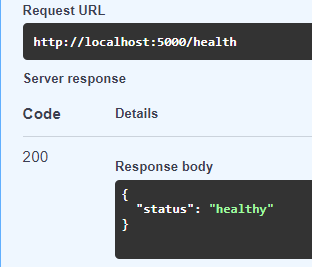
* http://localhost:5000/api/version - zwraca wersję serwisu 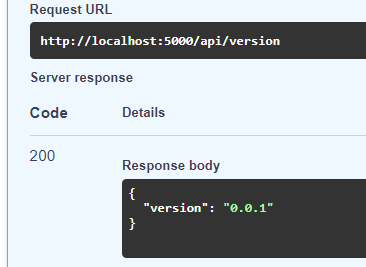
* http://localhost:5000/api/recommendation_models - zwraca dostępne modele rekomendacyjne 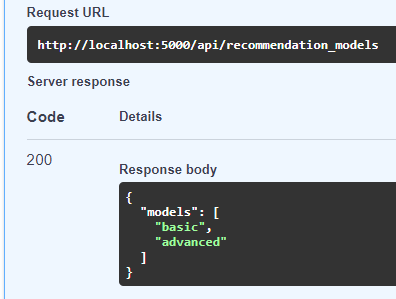
* http://localhost:5000/api/recommendation_models/model_id/recommend/<user_id> - zwraca rekomendacje dla danego użytkownika wygenerowane przez zadany model
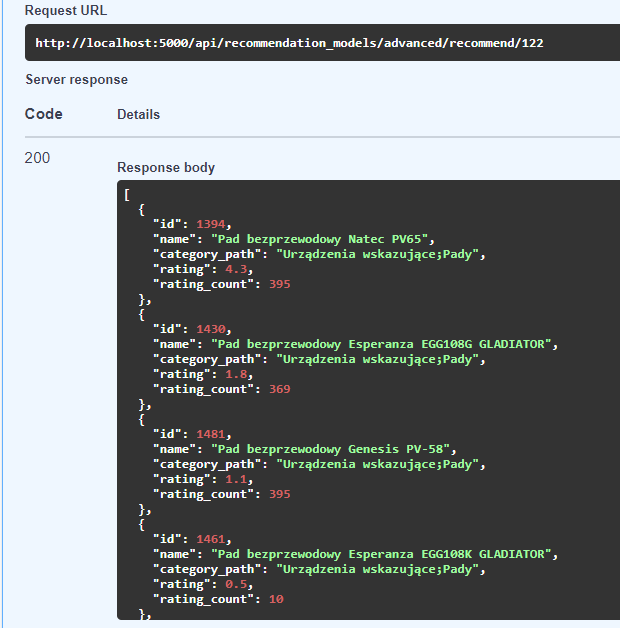
* http://localhost:5000/api/experiments/experiment_id/results - zwraca wyniki zadanego eksperymentu (offline lub online)
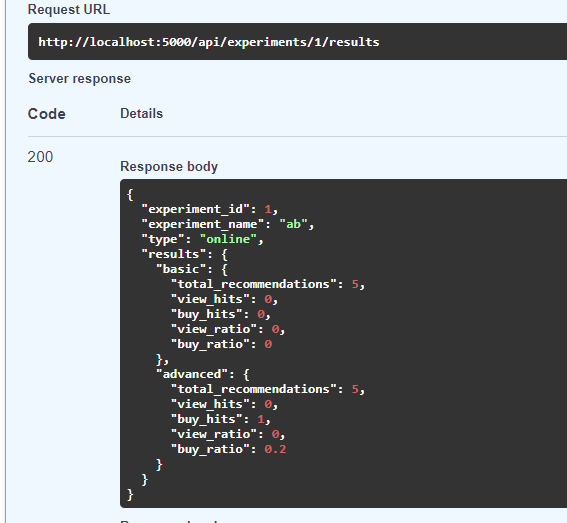
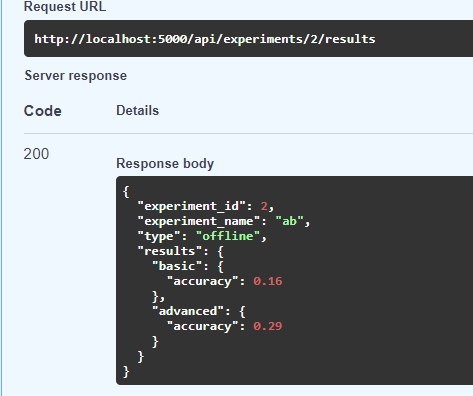
* http://localhost:5000/api/experiments/experiment_id/recommend/user_id - zwraca wyniki rekomendacji dla zadanego user_id i odpowiedniego eksperymentu (serwis sam przydziela model użytkownikowi na podstawie ustawień danego eksperymentu)
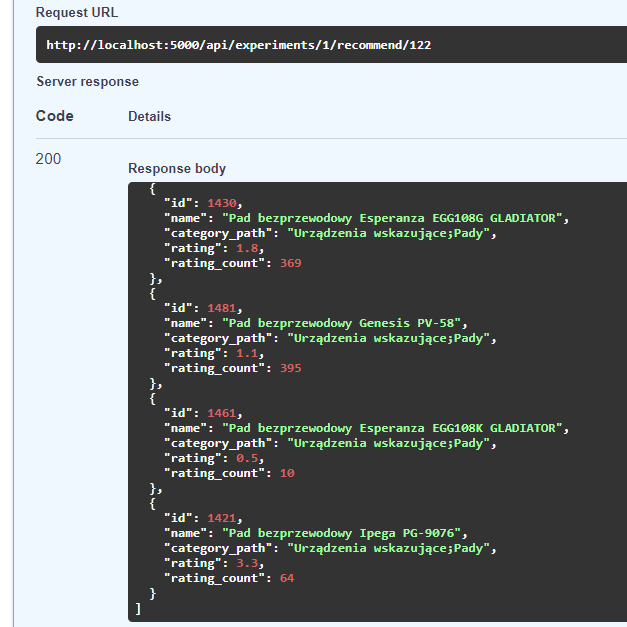
* http://localhost:5000/api/experiments - pokazuje infromacje o wszystkich eksperymentach
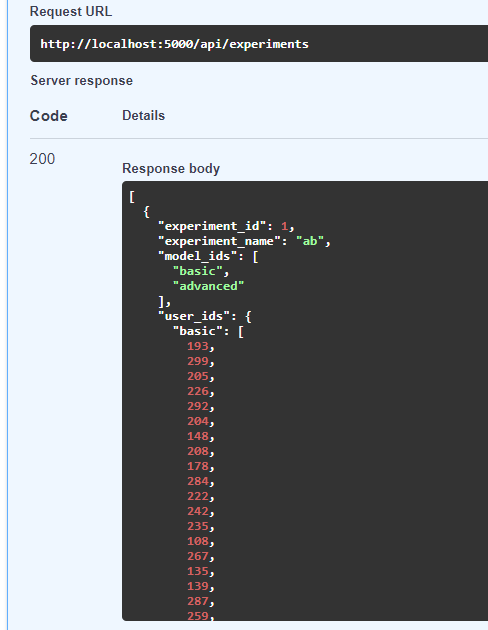
* http://localhost:5000/api/experiments/online/current/clear?experiment_id=experiment_id - usuwa logi eksperymentu online
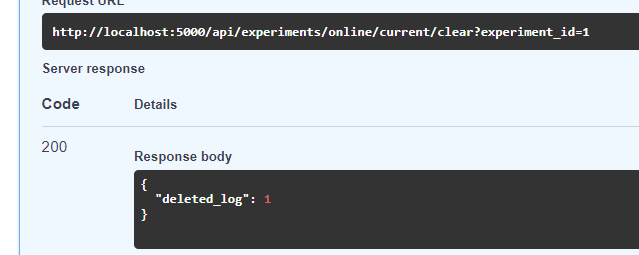
* http://localhost:5000/api/experiments/online/current - zwraca obecnie trwający eksperyment (online)
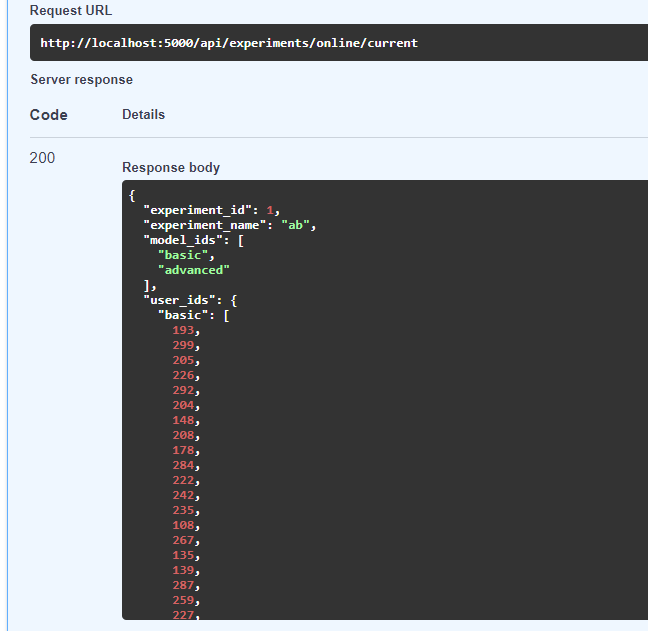
* (POST) http://localhost:5000/api/experiments/log/viewed - pozwala zalogować zdarzenie - kiedy użytkownik coś kupił (1) bądź wyświetlił (2). Dzięki temu można prowadzić statystyki dla eksperymentu online. Zakładamy że sklep internetowy w przypadku takiego zdarzenie wyśle request do naszego mikroserwisu 
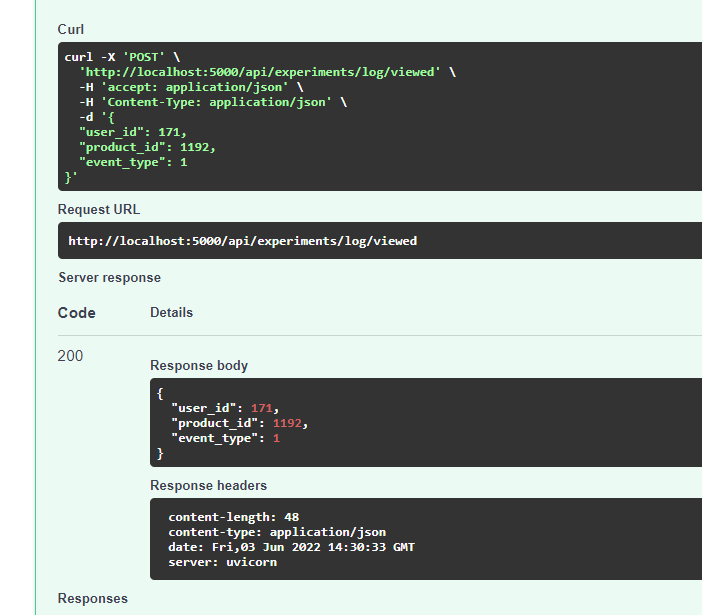

### Eksperymenty
Mikroserwis obsługuje dwa rodzaje eksperymentów. Online i offline. Offline zawsze zwróci wyniki dla danego zbioru użytkowników (opisane poniżej) zwalidowanych na zbiorze testowym.

Eksperyment online pozwala sam zbierać dane, a jako rezultat zwraca obiekt:
```json
{
  "experiment_id": 1,
  "experiment_name": "ab",
  "type": "online",
  "results": {
    "basic": {
      "total_recommendations": 5,
      "view_hits": 0,
      "buy_hits": 0,
      "view_ratio": 0,
      "buy_ratio": 0
    },
    "advanced": {
      "total_recommendations": 10,
      "view_hits": 0,
      "buy_hits": 1,
      "view_ratio": 0,
      "buy_ratio": 0.1
    }
  }
}
```
Zliczane są takie wartości jak: całkowita liczba rekomendacji obu modeli, liczba rekomendacji zakończonych obejrzeniem produktu, liczba rekomendacji zakończonych zakupem produktu oraz odpowiednie stosunki

#### Konfiguracja eksperymentu
Eksperymenty konfiguruje się poprzez edycję pliku `src/recommendation_service/experiments_data/experiments.json`

Plik konfiguracyjny wygląda następująco: 

```json
[
  {
    "id": 1,
    "type": "online",
    "name": "ab",
    "models": [
      "basic",
      "advanced"
    ],
    "user_sets": {
      "basic": [
        193,
        299,
        205,
        226,
        292,
        204,
      ],
      "advanced": [
        102,
        104,
        107,
        109,
        110,
        111,
        113, 
      ]
    }
  },
  {
    "id": 2,
    "type": "offline",
    "name": "ab",
    "models": [
      "basic",
      "advanced"
    ],
    "user_sets": {
      "basic": [
        206,
        172,
      ],
      "advanced": [
        206,
        172,
        225,
      ]
    }
  }
]
```
Można konfigurować typ eksperymentu, jego nazwę, modele które biorą udział oraz przydział użytkowników (user_id) per model